Dataset Head:
  Car_Name  Year  Selling_Price  Present_Price  Driven_kms Fuel_Type  \
0     ritz  2014           3.35           5.59       27000    Petrol   
1      sx4  2013           4.75           9.54       43000    Diesel   
2     ciaz  2017           7.25           9.85        6900    Petrol   
3  wagon r  2011           2.85           4.15        5200    Petrol   
4    swift  2014           4.60           6.87       42450    Diesel   

  Selling_type Transmission  Owner  
0       Dealer       Manual      0  
1       Dealer       Manual      0  
2       Dealer       Manual      0  
3       Dealer       Manual      0  
4       Dealer       Manual      0  

R2 SCORE: 0.9629514863268397
MAE: 0.6085131147540972

Top Important Features:
                    Feature  Importance
1             present_price    0.877691
0                      year    0.054686
2                driven_kms    0.032381
97   transmission_Automatic    0.006130
98      transmission_Manual    0.003752
77        ca

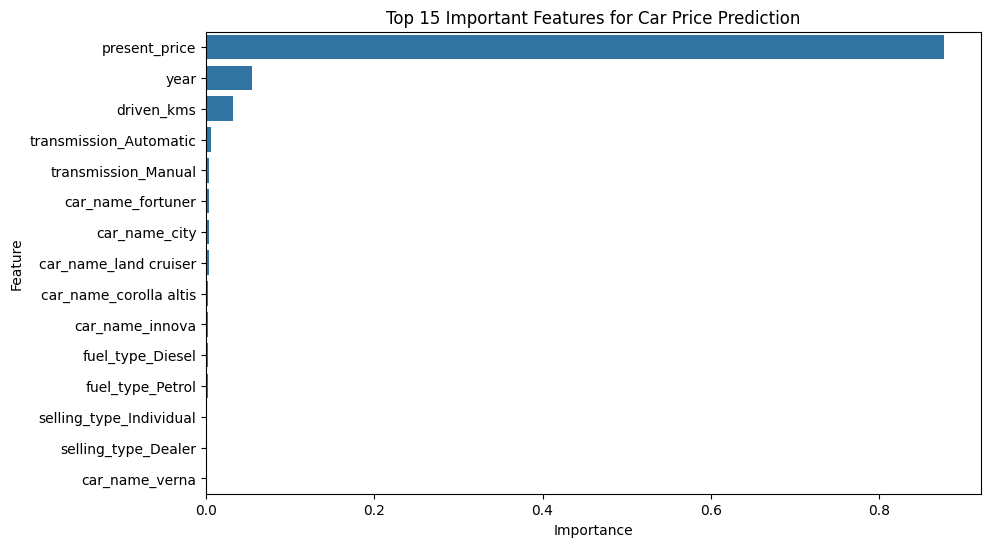

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import r2_score, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor

# 1. Load Dataset
df = pd.read_csv("car data.csv")

print("Dataset Head:")
print(df.head())

# 2. Basic Cleaning
df.columns = df.columns.str.strip().str.lower()

# remove rows with missing target
target_col = "selling_price"
df = df.dropna(subset=[target_col])

# optional cleanup for common numeric issues
def clean_numeric(val):
    if isinstance(val, str):
        return float(val.split()[0])
    return val

for col in ["mileage", "engine", "max_power"]:
    if col in df.columns:
        df[col] = df[col].apply(clean_numeric)

# 3. Select Features & Target
X = df.drop(columns=[target_col], errors='ignore')
y = df[target_col]

# Identify types
numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = X.select_dtypes(exclude=[np.number]).columns.tolist()

# 4. Preprocessing Pipeline
numeric_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

# 5. Full Model Pipeline
model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=300, random_state=42))
])

# 6. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 7. Train Model
model.fit(X_train, y_train)

# 8. Predictions
y_pred = model.predict(X_test)

# 9. Evaluation
print("\nR2 SCORE:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))

# 10. Feature Importance (from RandomForest)
reg = model.named_steps["regressor"]
importances = reg.feature_importances_

# extract feature names after one-hot encoding
encoded_cols = (
    model.named_steps["preprocessor"]
    .transformers_[1][1]
    .get_feature_names_out(categorical_features)
)

all_features = np.concatenate([numeric_features, encoded_cols])

# Top 15 important features
importance_df = pd.DataFrame({
    "Feature": all_features,
    "Importance": importances
}).sort_values(by="Importance", ascending=False).head(15)

print("\nTop Important Features:")
print(importance_df)

# 11. Plot feature importance
plt.figure(figsize=(10,6))
sns.barplot(x="Importance", y="Feature", data=importance_df)
plt.title("Top 15 Important Features for Car Price Prediction")
plt.show()